In [95]:
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from collections import defaultdict
from spacy.matcher import PhraseMatcher
import textacy
import pandas as pd

In [60]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.2 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [39]:
paragraph = """
    Hi! My name is Simon, and I'm CTO at Hyphen.

    At Hyphen, we have a bold vision to bring personal and private AI to the world. We believe that AI should be used to help people, not to exploit them. We are building a platform that will allow people to use AI to help them in their daily lives, without having to give up their privacy.
    We are currently hiring the most talented people we can find to help us bring this vision to life.

    My co-founders Yngvi and Kasper are both, like myself, seasoned founders and our values have brought us together for our most ambitious project yet.

    Our current team is small, consisting of Thomas (Product Manager), Andrei (Senior Fullstack/Architect) and Volodomyr (Senior Trust Engineer), and we are currently hiring for 2 open positions.

    When I'm not working, I like spending time with friends and family. Some of my hobbies include running, going to the gym, learning to play piano and playing badminton. I live in Copenhagen, a great city (especially in the summer).

    I also spend a lot of time reading and digesting knowledge, like the latest research in AI/ML and Self-Sovereign Identity.

    I really don't enjoy writing about myself, but if it can help us find the right Senior ML Engineer, then it's absolutely worth it :-)
    """

# Co-occurrence with simple NER from Spacy

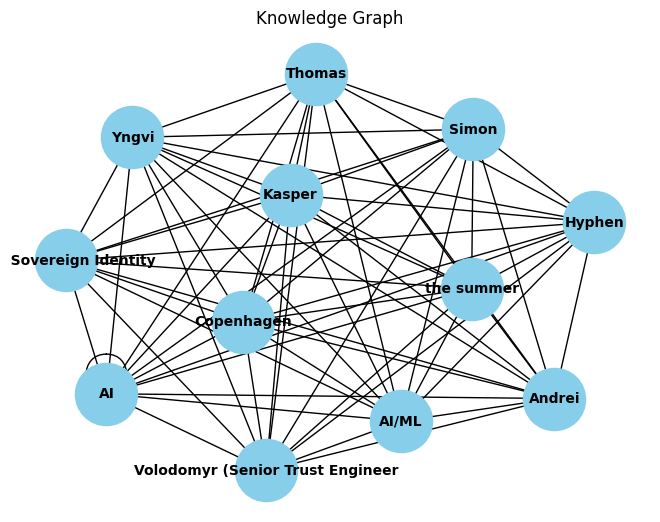

In [40]:
nlp = spacy.load('en_core_web_sm')

def entity_recognition_spacy(text):
    entities = []
    doc = nlp(text)
    
    for ent in doc.ents:
        if ent.label_ not in ('QUANTITY', 'CARDINAL'): 
            entities.append(ent.text)
    
    return entities

def relationship_extraction(entities):
    relationships = []
    
    # Creating relationships based on co-occurrence of entities in the paragraph
    for i in range(len(entities)):
        for j in range(i+1, len(entities)):
            relationships.append((entities[i], entities[j]))
    
    return relationships

def generate_knowledge_graph(entities, relationships):
    graph = nx.Graph()
    
    # Adding nodes (entities) to the graph
    graph.add_nodes_from(entities)
    
    # Adding edges (relationships) to the graph
    graph.add_edges_from(relationships)
    
    return graph

def plot_knowledge_graph(graph):
    pos = nx.spring_layout(graph, seed=42)  # Spring layout for better node placement
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Knowledge Graph")
    plt.show()


    
# Main code    
entities = entity_recognition_spacy(paragraph)
relationships = relationship_extraction(entities)
graph = generate_knowledge_graph(entities, relationships)
plot_knowledge_graph(graph)


# Co-occurrence with NER and custom job title entities

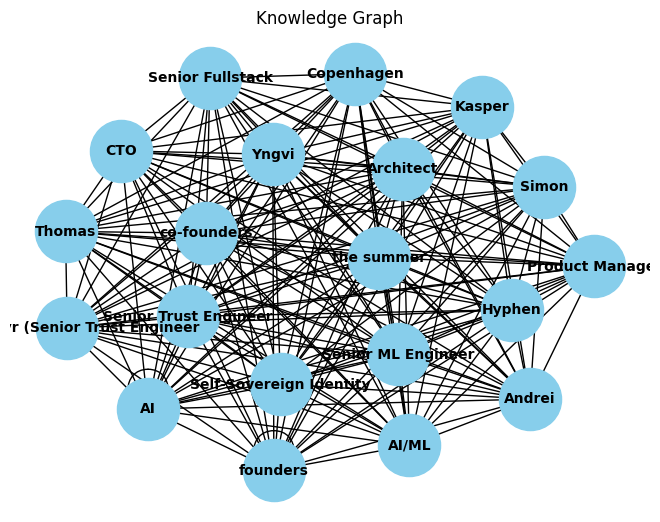

In [48]:
def entity_recognition_spacy(text):
    entities = []
    doc = nlp(text)
    
    for ent in doc.ents:
        if ent.label_ not in ('QUANTITY', 'CARDINAL'): 
            entities.append(ent.text)
    
    # Job titles recognition
    job_titles = ["CTO", "Product Manager", "Senior Fullstack", "Architect", "Senior Trust Engineer", "Senior ML Engineer", "co-founders", "founders"]
    phrase_matcher = PhraseMatcher(nlp.vocab)
    patterns = [nlp(title) for title in job_titles]
    phrase_matcher.add("JOB_TITLES", None, *patterns)
    
    matches = phrase_matcher(doc)
    for match_id, start, end in matches:
        entity = doc[start:end].text
        entities.append(entity)
    
    return entities


# Main code
entities = entity_recognition_spacy(paragraph)
relationships = relationship_extraction(entities)
graph = generate_knowledge_graph(entities, relationships)
plot_knowledge_graph(graph)

# Dependency parsing approach

In [80]:
# from text to a list of sentences
doc = nlp(paragraph.lower())
lst_docs = [sent for sent in doc.sents]
print("tot sentences:", len(lst_docs))

tot sentences: 13


In [84]:
## extract entities and relations from sentences
def entity_relationship_extraction(lst_docs):
    dic = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}
    
    for n,sentence in enumerate(lst_docs):
        lst_generators = list(textacy.extract.subject_verb_object_triples(sentence))  
        for sent in lst_generators:
            subj = "_".join(map(str, sent.subject))
            obj  = "_".join(map(str, sent.object))
            relation = "_".join(map(str, sent.verb))
            dic["id"].append(n)
            dic["text"].append(sentence.text)
            dic["entity"].append(subj.upper())
            dic["object"].append(obj)
            dic["relation"].append(relation)
    return dic


## create dataframe
dtf = pd.DataFrame(entity_relationship_extraction(lst_docs))

## examples
dtf.head(3)

,id,text,entity,relation,object
0,2,"at hyphen, we have a bold vision to bring pers...",WE,have,vision
1,3,we believe that ai should be used to help peop...,AI,should_be_used,"to_help_people_,_not_to_exploit_them"
2,4,we are building a platform that will allow peo...,WE,are_building,platform


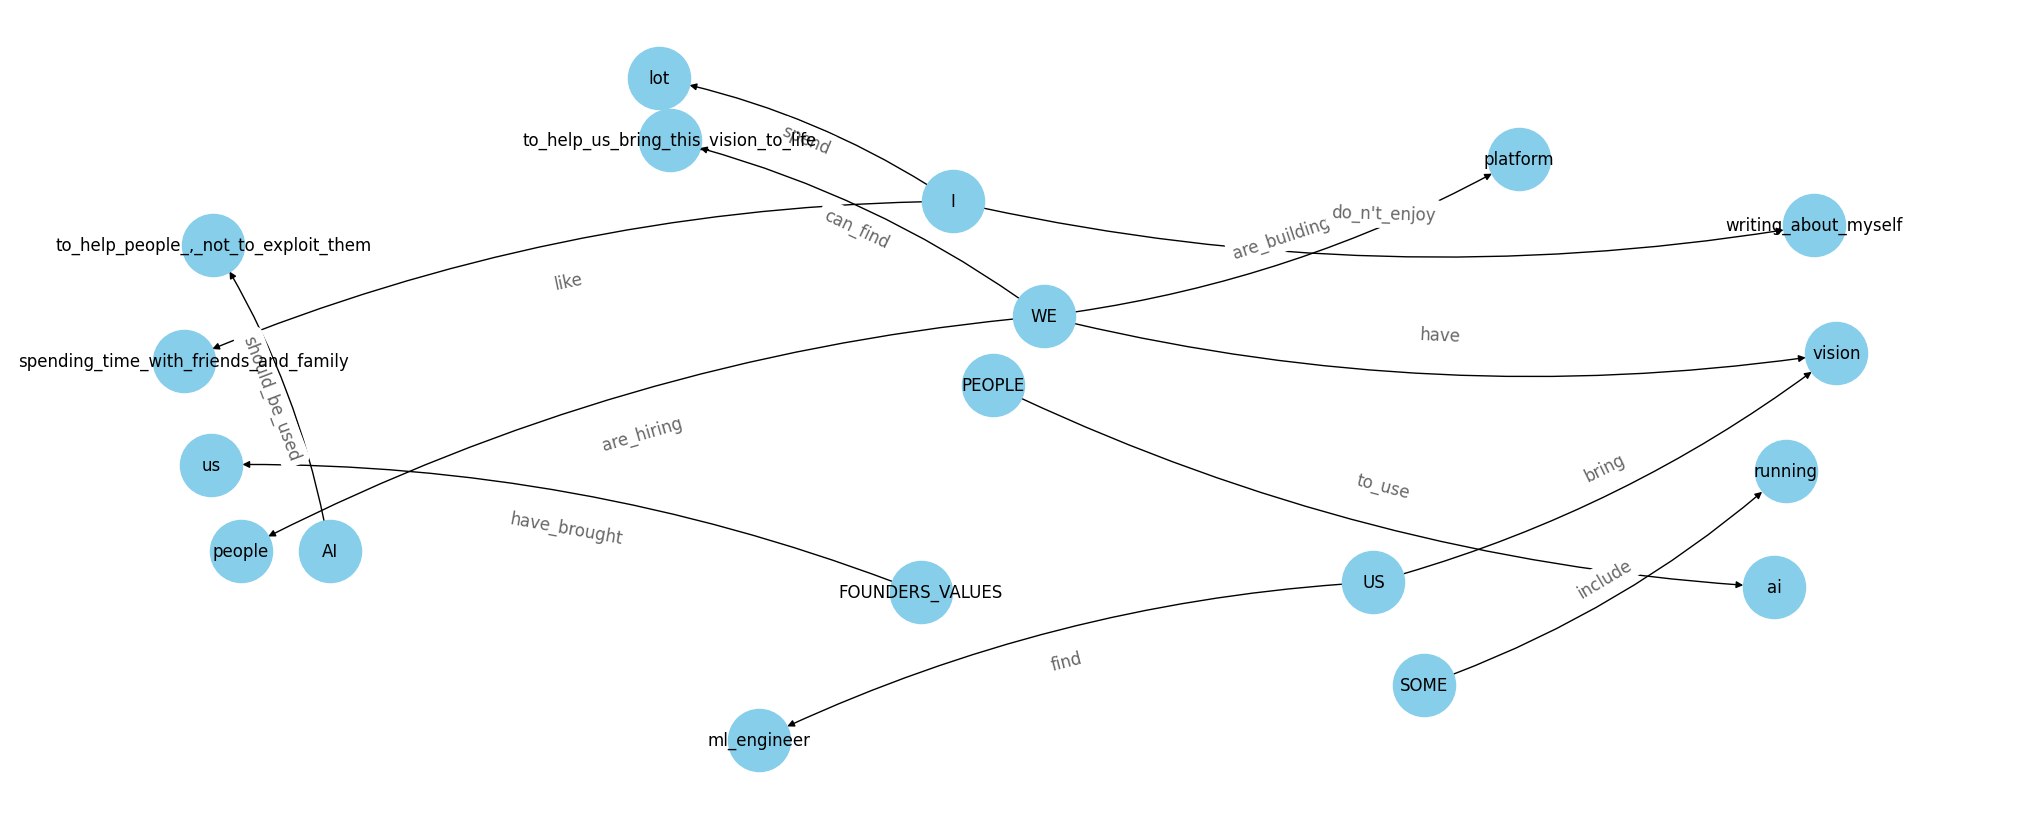

In [90]:
## create full graph
def generate_knowledge_graph(dtf):
    graph = nx.from_pandas_edgelist(dtf, source="entity", target="object", 
                            edge_attr="relation", 
                            create_using=nx.DiGraph())
    return graph

def plot_knowledge_graph(graph):
    plt.figure(figsize=(20,8))

    pos = nx.spring_layout(graph, k=1, seed=42)
    node_color = "skyblue"
    edge_color = "black"
    
    nx.draw(graph, pos=pos, with_labels=True, node_color=node_color, 
            edge_color=edge_color, 
            node_size=2000, connectionstyle='arc3,rad=0.1')
    
    nx.draw_networkx_edge_labels(graph, pos=pos, label_pos=0.5, 
                             edge_labels=nx.get_edge_attributes(graph,'relation'),
                             font_size=12, font_color='black', alpha=0.6)
    plt.show()


#Main code
graph = generate_knowledge_graph(dtf)
plot_knowledge_graph(graph)

# Next steps

The showed approaches could be considered initial steps in building a proper knowledge graph. 
If I had more time to explore other approaches I would consider doing the following:

- co-reference resolution: replacing pronouns with the referenced entities
- creating a custom list of entities to match: like I did with the job titles, but considering title-cased words, combination of words, synonims and/or aliases
-  entity disambiguation: for when different entities are called similarly